In [ ]:
!pip install pyomo shap ipopt -q

In [2]:
import pyomo.contrib.appsi.solvers.ipopt as ippot
import matplotlib.pyplot as plt
import pyomo.environ as poenv
import pandas as pd
import numpy as np
import sklearn
import shap

plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
X, y = shap.datasets.adult(display=True)
y = y.astype('float')
X.insert(0, 'BIAS', np.ones(X.shape[0]))

for column in ["Workclass", "Education-Num", "Marital Status", "Occupation", "Relationship", "Race", "Sex", "Country"]:
    one_hot = pd.get_dummies(X[column], prefix=column)

    X = X.drop(column, axis=1)
    X = X.join(one_hot)

features = X.columns.to_numpy()
train_idx, val_idx = sklearn.model_selection.train_test_split(X.index, test_size=0.2, random_state=7)

X_train = X.loc[train_idx]
y_train = y[train_idx]

X_val   = X.loc[val_idx]
y_val   = y[val_idx]

X['Age'] = (X['Age'] - X_train['Age'].mean())/X_train['Age'].std()
X["Hours per week"] = (X['Hours per week'] - X_train['Hours per week'].min())/(X_train['Hours per week'].max() - X_train['Hours per week'].min())


# X['Capital Loss'] = (X['Capital Loss'] - X_train['Capital Loss'].min())/(X_train['Capital Loss'].max() - X_train['Capital Loss'].min())
# X['Capital Gain'] = (X['Capital Gain'] - X_train['Capital Gain'].min())/(X_train['Capital Gain'].max() - X_train['Capital Gain'].min())

X['Capital Loss'] = X['Capital Loss'].apply(np.log1p)
X['Capital Gain'] = X['Capital Gain'].apply(np.log1p)

In [4]:
X_train.head()

,BIAS,Age,Capital Gain,Capital Loss,Hours per week,Workclass_ ?,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
12011,1.0,51.0,0.0,0.0,40.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
23599,1.0,51.0,0.0,0.0,50.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23603,1.0,21.0,0.0,0.0,40.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
6163,1.0,25.0,0.0,0.0,24.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
14883,1.0,48.0,0.0,0.0,38.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [5]:
exp = np.vectorize(poenv.exp)
log = np.vectorize(poenv.log)

In [6]:
model = poenv.ConcreteModel()

# SETS (used to index the decision variable and the parameters)
model.features = poenv.Set(initialize=features)

# VARIABLES
model.theta = poenv.Var(model.features, bounds=(-float('inf'), float('inf')))

logits = np.array([X_train[feat] * model.theta[feat] for feat in model.features]).sum(axis=0)

w = 1

error = (1 + (w - 1) * y_train) * log(1 + exp(-logits)) + (1 - y_train) * logits

loss = sum(error) / len(error)

model.objective = poenv.Objective(expr = loss, sense=poenv.minimize)

In [7]:
ippot.Ipopt().solve(model)

theta = pd.Series([model.theta[feat]() for feat in model.features], model.features)

In [8]:
theta

BIAS                       -3.256657
Age                         0.024111
Capital Gain                0.000339
Capital Loss                0.000675
Hours per week              0.028775
                              ...   
Country_ Thailand          -0.102007
Country_ Trinadad&Tobago    0.231412
Country_ United-States      0.684157
Country_ Vietnam           -0.045848
Country_ Yugoslavia         1.795691
Length: 107, dtype: float64

In [9]:
logits = X_train @ theta

probs  = 1/(1 + np.exp(-logits))
labels = np.where(probs >= 0.5, 1, 0)

sklearn.metrics.roc_auc_score(y_train, probs)

0.9091916637964799

In [10]:
perf = sklearn.metrics.recall_score(y_train, labels)
perf_man = sklearn.metrics.recall_score(y_train[X_train["Sex_ Male"] == 1], labels[X_train["Sex_ Male"] == 1])
perf_woman = sklearn.metrics.recall_score(y_train[X_train["Sex_ Female"] == 1], labels[X_train["Sex_ Female"] == 1])
print('Recall', perf, perf_man, perf_woman)

Recall 0.6077400860009555 0.6235250046825248 0.5180851063829788


In [11]:
perf = sklearn.metrics.precision_score(y_train, labels)
perf_man = sklearn.metrics.precision_score(y_train[X_train["Sex_ Male"] == 1], labels[X_train["Sex_ Male"] == 1])
perf_woman = sklearn.metrics.precision_score(y_train[X_train["Sex_ Female"] == 1], labels[X_train["Sex_ Female"] == 1])
print('Precision', perf, perf_man, perf_woman)

Precision 0.7351184742824118 0.735528060097216 0.7323308270676692


In [14]:
logits = X_val @ theta

probs  = 1/(1 + np.exp(-logits))
labels = np.where(probs >= 0.5, 1, 0)

sklearn.metrics.roc_auc_score(y_val, probs)

perf = sklearn.metrics.recall_score(y_val, labels)
perf_man = sklearn.metrics.recall_score(y_val[X_val["Sex_ Male"] == 1], labels[X_val["Sex_ Male"] == 1])
perf_woman = sklearn.metrics.recall_score(y_val[X_val["Sex_ Female"] == 1], labels[X_val["Sex_ Female"] == 1])
print(f'Overall Recall {perf}')
print(f'Male Recall    {perf_man}')
print(f'Female Recall  {perf_woman}')

Overall Recall 0.5998719590268886
Male Recall    0.6190476190476191
Female Recall  0.49372384937238495


In [15]:
perf = sklearn.metrics.precision_score(y_val, labels)
perf_man = sklearn.metrics.precision_score(y_val[X_val["Sex_ Male"] == 1], labels[X_val["Sex_ Male"] == 1])
perf_woman = sklearn.metrics.precision_score(y_val[X_val["Sex_ Female"] == 1], labels[X_val["Sex_ Female"] == 1])
print(f'Overall Precision {perf}')
print(f'Male Precision    {perf_man}')
print(f'Female Precision  {perf_woman}')

Overall Precision 0.7383766745468873
Male Precision    0.7338709677419355
Female Precision  0.7712418300653595


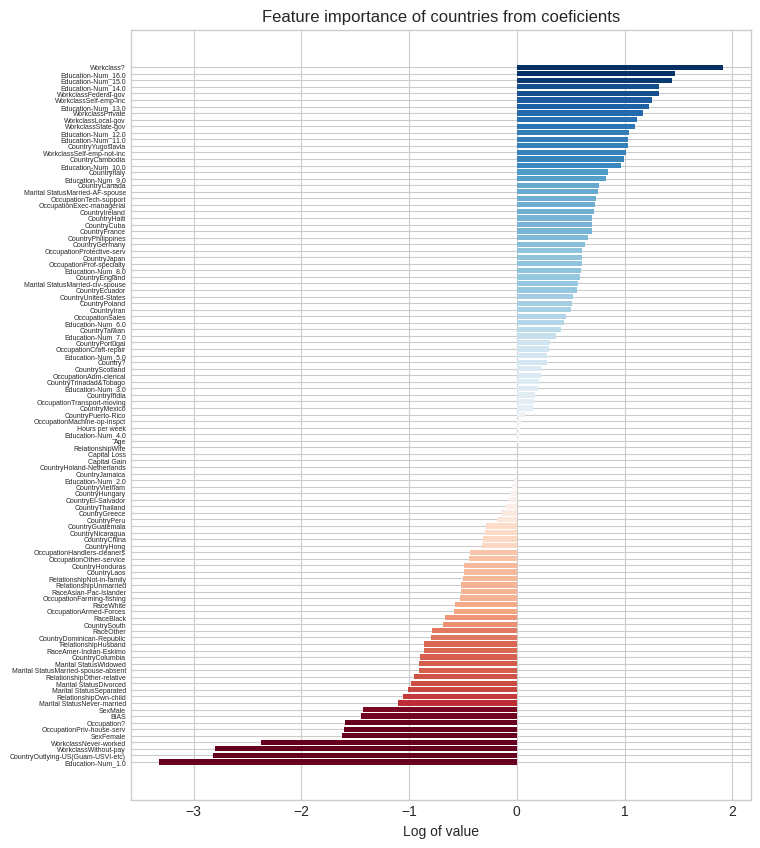

In [18]:
fig, ax = plt.subplots(figsize=(8, 10))

coefs = np.sign(theta) * np.log1p(np.abs(theta))

category = ""

coefs = coefs[[feature for feature in features if category in feature]]

n = len(coefs)

idxs = np.argsort(coefs)

coefs = coefs[idxs]

bars = plt.barh(np.arange(n), coefs, color=plt.get_cmap("RdBu")((coefs/3 + 0.5)))

plt.title("Feature importance of countries from coeficients")
plt.yticks(range(n), labels = [feature.replace(f"{category}_ ", "") for feature in coefs.keys()], fontsize=5)
plt.xlabel("Log of value")
plt.savefig("plots/importance_country.svg", transparent=True, bbox_inches="tight")
plt.show()

Resultados originais:

In [9]:
prob = {idx: 1/(1+np.exp(-X.loc[idx]@theta)) for idx in train_idx}
sklearn.metrics.roc_auc_score(y[train_idx], [prob[idx] for idx in train_idx])

0.8881783194398247

In [10]:
prob = {idx: 1/(1+np.exp(-X.loc[idx]@theta)) for idx in train_idx}

perf = sklearn.metrics.recall_score(y[train_idx], [prob[idx]>0.5 for idx in train_idx])
perf_man = sklearn.metrics.recall_score(y[train_idx_m], [prob[idx]>0.5 for idx in train_idx_m])
perf_woman = sklearn.metrics.recall_score(y[train_idx_w], [prob[idx]>0.5 for idx in train_idx_w])
print('Recall', perf, perf_man, perf_woman)

Recall 0.5451505016722408 0.5716426297059375 0.3946808510638298


In [11]:
prob = {idx: 1/(1+np.exp(-X.loc[idx]@theta))for idx in val_idx}

perf = sklearn.metrics.recall_score(y[val_idx], [prob[idx]>0.5 for idx in val_idx])
perf_man = sklearn.metrics.recall_score(y[val_idx_m], [prob[idx]>0.5 for idx in val_idx_m])
perf_woman = sklearn.metrics.recall_score(y[val_idx_w], [prob[idx]>0.5 for idx in val_idx_w])
print('Recall', perf, perf_man, perf_woman)

Recall 0.5454545454545454 0.5789871504157218 0.3598326359832636


## Weighted

In [6]:
weighted_model = poenv.ConcreteModel()

# SETS (used to index the decision variable and the parameters)
weighted_model.features = poenv.Set(initialize=features)

# VARIABLES
weighted_model.theta = poenv.Var(weighted_model.features, bounds=(-float('inf'), float('inf')))

logits = np.array([X_train[feat] * weighted_model.theta[feat] for feat in weighted_model.features]).sum(axis=0)

w = 1

error = (1 + (w - 1) * y_train) * log(1 + exp(-logits)) + (1 - y_train) * logits

loss_women = sum(error[X_train["Sex_ Male"] == 1])
loss_men   = sum(error[X_train["Sex_ Female"] == 1])

Nm, Nw = (X_train["Sex_ Male"] == 1).sum(), (X_train["Sex_ Female"] == 1).sum()

In [7]:
from tqdm.notebook import tqdm

weights = np.logspace(-2, 2, num=40)

logits = np.zeros((len(weights), len(y_val)))
thetas = np.zeros((len(weights), len(features)))

for i, weight in tqdm(enumerate(weights), total=len(weights)):
    weighted_model.add_component('objective', poenv.Objective(expr = (loss_men + weight * loss_women)/(Nm + weight * Nw), sense=poenv.minimize))

    ippot.Ipopt().solve(weighted_model)

    thetas[i] = [weighted_model.theta[feat]() for feat in weighted_model.features] 
    logits[i] = X_val @ thetas[i]

    weighted_model.del_component('objective')

  0%|          | 0/40 [00:00<?, ?it/s]

In [8]:
probs  = 1/(1 + np.exp(-logits))

labels = np.where(probs >= 0.5, 1, 0)

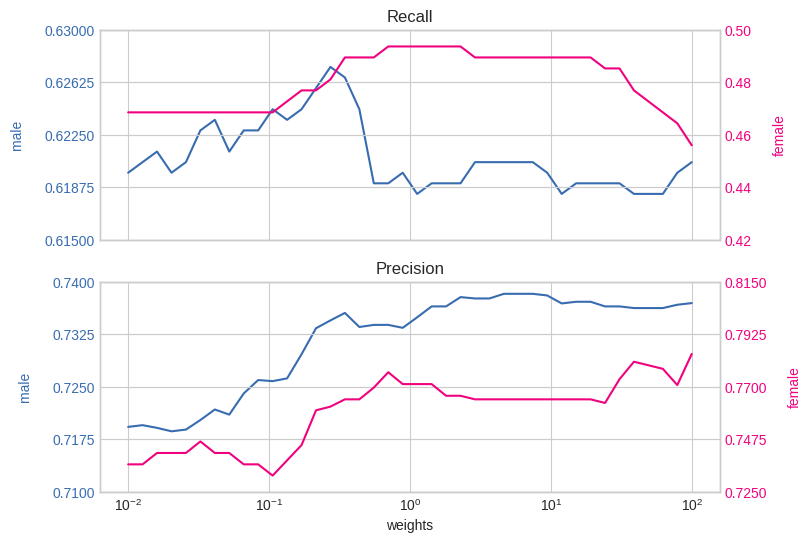

In [9]:
fig, axs = plt.subplots(nrows=2, figsize=(8, 6), sharex=True)
axw0 = axs[0].twinx()

axs[0].set_title("Recall")

axs[0].plot(weights, [sklearn.metrics.recall_score(y_val[X_val["Sex_ Male"] == 1], label[X_val["Sex_ Male"] == 1]) for label in labels], label="Male recall", color="#386cb0")
axw0.plot(weights, [sklearn.metrics.recall_score(y_val[X_val["Sex_ Female"] == 1], label[X_val["Sex_ Female"] == 1]) for label in labels], label="Female recall", color="#f0027f")

axs[0].set_ylabel('male', color="#386cb0", labelpad=15)
axw0.set_ylabel('female', color="#f0027f", labelpad=15)

axs[0].tick_params(axis='y', labelcolor="#386cb0")
axw0.tick_params(axis='y', labelcolor="#f0027f")

axw1 = axs[1].twinx()

axs[1].set_title("Precision")

axs[1].plot(weights, [sklearn.metrics.precision_score(y_val[X_val["Sex_ Male"] == 1], label[X_val["Sex_ Male"] == 1]) for label in labels], label="Male precision", color="#386cb0")
axw1.plot(weights, [sklearn.metrics.precision_score(y_val[X_val["Sex_ Female"] == 1], label[X_val["Sex_ Female"] == 1]) for label in labels], label="Female precision", color="#f0027f")

axs[1].set_ylabel('male', color="#386cb0", labelpad=15)
axw1.set_ylabel('female', color="#f0027f", labelpad=15)

axs[1].tick_params(axis='y', labelcolor="#386cb0")
axw1.tick_params(axis='y', labelcolor="#f0027f")

axs[1].set_xlabel("weights")
axs[1].set_xscale('log')

axs[0].set_ylim(0.615, 0.63)
axw0.set_ylim(0.42, 0.5)

axs[1].set_ylim(0.71, 0.74)
axw1.set_ylim(0.725, 0.815)

import matplotlib.ticker
nticks = 5
axs[0].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
axw0.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))

axs[1].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
axw1.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))

plt.savefig('plots/weighted_other.svg', transparent=True)

plt.show()